### Political Polarization Calculations using BHPS 2004 data

In [1]:
import pandas as pd
import os
import time
import numpy as np

In [2]:
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

Download data from <a href = "https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5151#!/access-data"> UK data service </a> website. The data would be in <b> SPSS </b> format. To read and convert these files, use <code> pip install pyreadstat </code> and then use <code> df = pd.read_spss("file path") </code>. Convert the dataframe to CSV using <code> df.to_csv("file.csv") </code>. 

In [3]:
# Each year has a {string}indresp.csv combination
df_residence = pd.read_csv("nindresp.csv")

C:\Users\Sidrcs\anaconda3\envs\PySAL\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (8,9,29,928,929,1047,1158,1276,1278,1281) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Interested variables for visualization
Look for <code>nindresp.csv</code>. Required variables are: (These are columns names and their corresponding interpretation) <ul><li><code>nopsocc</code> : "Private enterprise is the best way to solve Britain’s economic problems" (S1)</li> <li><code>nopsocd</code> : "Major public services and industries ought to be in state ownership" (S2)</li> <li><code>nopsoce</code> : "It is the government’s responsibility to provide a job for everyone who wants one" (S3)</li> <li><code>nfiyr</code> : <b>Self-reported annual income</b> </li> <li><code>nfetype</code> : <b>Educational qualification</b></li> <li><code>nplbornc_cc</code> : <b>Country of birth</b></li> <li><code>nage12</code> : <b>Age</b></li> <li><code>njbstatt</code> : <b>Employment status</b></li> <li><code>nregion2</code> : <b>UK region name</b> </li></ul>

In [4]:
# Loading variables of interest from 2004 BHPS dataset into dataframe
df_residence = df_residence[["nopsocc","nopsocd","nopsoce","nfiyr","nfetype","nage12","njbstatt","nregion2", "nplbornc_cc"]]

In [5]:
# Dropping rows that donot have any spatial information associated with them
df_residence = df_residence[~df_residence["nregion2"].isin(["don't know", "inapplicable", "missing or wild", "refused"])]

In [6]:
# To view columns
df_residence.head()

,nopsocc,nopsocd,nopsoce,nfiyr,nfetype,nage12,njbstatt,nregion2,nplbornc_cc
0,Strongly agree,Disagree,Disagree,45694.3984375,inapplicable,70.0,Retired,London,inapplicable
1,Agree,Disagree,Disagree,12363.2216796875,inapplicable,67.0,Retired,London,inapplicable
2,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,23.0,proxy and/or phone,London,proxy and/or phone
3,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,49.0,proxy and/or phone,London,proxy and/or phone
4,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,proxy and/or phone,23.0,proxy and/or phone,London,proxy and/or phone


In [7]:
# checking different types of opinions provided for statement when surveyed
df_residence['nopsocc'].value_counts()

Neither agree/disagree    6581
Disagree                  3646
Agree                     2817
proxy and/or phone        1013
don't know                 683
Strongly disagree          599
Strongly agree             387
refused                      3
missing or wild              1
Name: nopsocc, dtype: int64

In [23]:
# create an empty dataframe
output_df = pd.DataFrame()

# Group the dataframe by county and calculate standard deviation of age : "nage12"
output_df["Standard Deviation of Age"] = df_residence.groupby("nregion2")["nage12"].agg("std")

# Group the dataframe by county and number of people born in UK : "nplbornc_cc"
output_df["born"] = df_residence.groupby("nregion2")["nplbornc_cc"]

# Assuming inapplicable as people born in UK to all others
def native_share(x):
    pop_count = list(x["born"][1])
    native_count = pop_count.count("inapplicable")/len(pop_count)
    return native_count

# calculating fraction of natives in each county
output_df["Native Share Variability"] = output_df.apply(lambda x: native_share(x), axis = 1)

# Dropping "born" groupby column
output_df = output_df.drop(columns = ["born"], axis = 1)

# Creating afetype_dict based on PDF from 2004 BHPS data
nfetype_dict = {"Nursing school etc" : 1, "College of f educ" : 2, "Other trng establmnt" : 3, "Polytechnic" : 4, \
                "University" : 5, "None of the above" : 7, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy and/or phone" : -7, "refused" : -2}


# Create a new column "nfetype_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nfetype_encoded"] = df_residence["nfetype"].replace(nfetype_dict)

# Group the dataframe by county and "nfetype_encoded"
output_df["education"] = df_residence.groupby("nregion2")["nfetype_encoded"]

# function to calculate dissimilarity in education
def dissimilarity_education(x):
    # loads tuple element into job
    job = x["education"][1]
    # loads frequency of each education type in county as list
    freq = list(job.value_counts())
    # calculates total number of groups
    s = len(freq)
    dissim_index = 0
    for i in freq:
        # formula of dissimilarity index
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

def region_name(x):
    return x["education"][0]

output_df["Education Variability"] = output_df.apply(lambda x: dissimilarity_education(x), axis = 1)
output_df["region_name"] = output_df.apply(lambda x: region_name(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["education"], axis = 1)

# Creating ajbstatt_dict based on PDF from 2000 BHPS data
njbstatt_dict = {"Self employed" : 1, "In paid employ" : 2, "Unemployed" : 3, "Retired" : 4, "Maternity leave" : 5, \
                    "Family care" : 6,  "FT studt, school" : 7, " LT sick, disabld" : 8, \
                    "Govt trng scheme" : 9, "Something else" : 10, "don't know" : -1, "missing or wild" : -9, \
                    "inapplicable" : -8, "proxy" : -7, "refused" : -2}


# Create a new column "ajbstatt_encoded" in the dataframe by replacing the values with encoded values from the dictionary
#df_residence.loc["njbstatt_encoded"] = df_residence["njbstatt"].replace(njbstatt_dict)
df_residence.loc[:, "njbstatt_encoded"] = df_residence["njbstatt"].replace(njbstatt_dict)

# Group the dataframe by county and calculate the mean and standard deviation of the encoded values
output_df["job"] = df_residence.groupby("nregion2")["njbstatt_encoded"]

# function to calculate dissimilarity in job
def dissimilarity_job(x):
    job = x["job"][1]
    freq = list(job.value_counts())
    s = len(freq)
    dissim_index = 0
    for i in freq:
        dissim_index += 0.5 * abs(i-(1/s))
    return dissim_index

# function to calculate fraction of employed people within each county
def frac_employed(x):
    job = list(x["job"][1])
    frac_emp = (job.count(2)/len(job))
    return frac_emp

output_df["Job Variability"] = output_df.apply(lambda x: dissimilarity_job(x), axis = 1)
output_df ["Fraction of Employed"] = output_df.apply(lambda x: frac_employed(x), axis = 1)

# Dropping "education" groupby column
output_df = output_df.drop(columns = ["job"], axis = 1)

# replacing all Not-A-Number cases to zero i.e., proxy values
df_residence.loc[:, "nfiyr"] = df_residence["nfiyr"].replace("proxy and/or phone",0).astype("float32")

# Group the dataframe by county and calculate median based on self-reported annual income: "nfiyr"
output_df["median_income"] = df_residence.groupby("nregion2")["nfiyr"].agg(["median"])

# convert "nfiyr" column to float data type
df_residence["nfiyr"] = df_residence["nfiyr"].astype("float32")

# group incomes by county
output_df["income"] = df_residence.groupby("nregion2")["nfiyr"]

def gini_index(x):
    data = list(x["income"][1])
    # sort the data in ascending order
    sorted_data = np.sort(data)
    # calculate the cumulative sum of the sorted data
    cumsum_data = np.cumsum(sorted_data)
    # calculate the Lorenz curve values
    lorenz_curve = cumsum_data / cumsum_data[-1]
    # calculate the area under the Lorenz curve
    area_lorenz_curve = np.trapz(lorenz_curve, dx=1/len(data))
    # calculate the Gini index
    gini_index = 1 - 2 * area_lorenz_curve
    return gini_index

output_df["Gini Index of Income Inequality"] = output_df.apply(lambda x : gini_index(x), axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["income"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,median_income,Gini Index of Income Inequality
nregion2,,,,,,,,
Channel Islands,33.234019,1.000000,0.5,Channel Islands,0.5,0.000000,12763.849609,0.292305
East Midlands,16.894359,0.998496,332.0,East Midlands,332.0,0.560902,11966.052734,0.428035
East of England,18.785432,0.997433,389.0,East of England,389.0,0.509628,12576.395508,0.472250
London,17.580476,0.992296,324.0,London,324.0,0.562404,15126.498047,0.457080
North East,18.025846,0.997110,172.5,North East,172.5,0.546243,12523.220703,0.410948
North West,18.000089,0.997938,484.5,North West,484.5,0.558763,12247.130859,0.430435
Northern Ireland,17.990948,0.997461,1181.0,Northern Ireland,1181.0,0.450275,10714.531250,0.436799
Scotland,17.646588,0.997967,1229.5,Scotland,1229.5,0.539024,12065.650391,0.423826
South East,17.993948,0.997263,547.5,South East,547.5,0.566606,13810.888672,0.439654


In [24]:
# Define the dictionary to encode the "nopsocc" column which is Statement 1 (S1) by keeping valid statement only
# S1: "Private enterprise is the best way to solve Britain’s economic problems."
nopsocc_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "nopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsocc_encoded"] = df_residence["nopsocc"].replace(nopsocc_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsocc_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S1"] = df_residence.groupby("nregion2")["nopsocc_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsocc_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsocc_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S1"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsocc_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S1"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,median_income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1
nregion2,,,,,,,,,,,
Channel Islands,33.234019,1.000000,0.5,Channel Islands,0.5,0.000000,12763.849609,0.292305,0.500000,1.500000,125.000000
East Midlands,16.894359,0.998496,332.0,East Midlands,332.0,0.560902,11966.052734,0.428035,0.737870,0.592481,2.483531
East of England,18.785432,0.997433,389.0,East of England,389.0,0.509628,12576.395508,0.472250,0.681227,0.559692,2.271565
London,17.580476,0.992296,324.0,London,324.0,0.562404,15126.498047,0.457080,0.792059,0.610169,4.644171
North East,18.025846,0.997110,172.5,North East,172.5,0.546243,12523.220703,0.410948,0.668451,0.598266,0.304381
North West,18.000089,0.997938,484.5,North West,484.5,0.558763,12247.130859,0.430435,0.786281,0.640206,2.041054
Northern Ireland,17.990948,0.997461,1181.0,Northern Ireland,1181.0,0.450275,10714.531250,0.436799,0.767531,0.612357,2.537036
Scotland,17.646588,0.997967,1229.5,Scotland,1229.5,0.539024,12065.650391,0.423826,0.718936,0.613008,0.854105
South East,17.993948,0.997263,547.5,South East,547.5,0.566606,13810.888672,0.439654,0.644736,0.547445,0.922715


In [25]:
# Define the dictionary to encode the "nopsocd" column which is Statement 2 (S2)
# S2: "Major public services and industries ought to be in state ownership."

jopsocd_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "nopsocc_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsocd_encoded"] = df_residence["nopsocd"].replace(jopsocd_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsocd_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S2"] = df_residence.groupby("nregion2")["nopsocd_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsocd_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsocd_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S2"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsocd_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S2"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

In [26]:
# Define the dictionary to encode the "nopsocd" column which is Statement 3 (S3)
# S3: "It is the government’s responsibility to provide a job for everyone who wants one."

nopsoce_dict = {"Strongly agree": 2,"Agree":1, "Neither agree/disagree":0, "Disagree":-1 , "Strongly disagree": -2,
                "Not agree, disagree": -3 , 
                "don't know": -3 , "missing or wild": -3, "inapplicable":-3,
                "proxy and/or phone":-3, "refused":-3}

# Create a new column "jopsocd_encoded" in the dataframe by replacing the values with encoded values from the dictionary
df_residence.loc[:, "nopsoce_encoded"] = df_residence["nopsoce"].replace(nopsoce_dict)

#remove -3 valued rows from df_residence[nopsocc_encoded]
df_residence = df_residence[df_residence['nopsoce_encoded'] != -3]

# Political polarization measurement by Lindqvist and Ostling (2010)
output_df["Lindqvist_Ostling_S3"] = df_residence.groupby("nregion2")["nopsoce_encoded"].agg(["var"])

# Create new columns based on absolute sum of encoded values of opinions and counts
output_df["abs_sum"] = df_residence.groupby("nregion2")["nopsoce_encoded"].apply(lambda x: x.abs().sum())
output_df["counts"] = df_residence.groupby("nregion2")["nopsoce_encoded"].apply(lambda x: x.count())

# Political polarization measurement by Abramowitz and Saunders (2008)
output_df["Abramowitz_Saunders_S3"] = output_df.apply(lambda x: x["abs_sum"]/x["counts"], axis = 1)

output_df = output_df.drop(columns = ["abs_sum", "counts"], axis = 1)

# Group the dataframe by county and nopsocc_encoded values
output_df["dkp"] = df_residence.groupby("nregion2")["nopsoce_encoded"]

# Political polarization measurement by Duca and Saving (2016)
def duca_saving(x):
    county_tuple = x["dkp"]
    freq = list(county_tuple[1].value_counts())
    val = list(county_tuple[1].unique())
    norm_freq = [i/sum(freq) for i in freq]
    outer_sum = 0
    for i in range(len(norm_freq)):
        nkit = norm_freq[i]
        inner_sum = 0
        for j in range(len(norm_freq)):
            npit = norm_freq[j]
            dkp = abs(val[i] - val[j])
            inner_sum += npit*dkp
    outer_sum += (nkit**2)*inner_sum
    
    return outer_sum

output_df["Duca_Saving_S3"] = output_df.apply(lambda x: duca_saving(x)*1000, axis = 1)

# Drop "income" groupby column
output_df = output_df.drop(columns = ["dkp"], axis = 1)

output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,median_income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
nregion2,,,,,,,,,,,,,,,,,
Channel Islands,33.234019,1.000000,0.5,Channel Islands,0.5,0.000000,12763.849609,0.292305,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000
East Midlands,16.894359,0.998496,332.0,East Midlands,332.0,0.560902,11966.052734,0.428035,0.737870,0.592481,2.483531,0.894225,0.708271,2.322293,1.168530,0.912782,8.061817
East of England,18.785432,0.997433,389.0,East of England,389.0,0.509628,12576.395508,0.472250,0.681227,0.559692,2.271565,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369
London,17.580476,0.992296,324.0,London,324.0,0.562404,15126.498047,0.457080,0.792059,0.610169,4.644171,1.000105,0.785824,3.116318,1.276732,0.966102,9.327323
North East,18.025846,0.997110,172.5,North East,172.5,0.546243,12523.220703,0.410948,0.668451,0.598266,0.304381,0.881897,0.705202,3.170316,1.028232,0.890173,1.449022
North West,18.000089,0.997938,484.5,North West,484.5,0.558763,12247.130859,0.430435,0.786281,0.640206,2.041054,0.954796,0.749485,5.118481,1.201915,0.942268,8.285364
Northern Ireland,17.990948,0.997461,1181.0,Northern Ireland,1181.0,0.450275,10714.531250,0.436799,0.767531,0.612357,2.537036,0.955765,0.742277,4.572184,1.227427,0.977994,3.223163
Scotland,17.646588,0.997967,1229.5,Scotland,1229.5,0.539024,12065.650391,0.423826,0.718936,0.613008,0.854105,0.871462,0.710569,2.132903,1.149324,0.937805,3.620101
South East,17.993948,0.997263,547.5,South East,547.5,0.566606,13810.888672,0.439654,0.644736,0.547445,0.922715,0.871359,0.739964,0.962744,1.110175,0.902372,5.759079


In [27]:
output_df.reset_index(drop=True, inplace=True)
output_df

,Standard Deviation of Age,Native Share Variability,Education Variability,region_name,Job Variability,Fraction of Employed,median_income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,33.234019,1.000000,0.5,Channel Islands,0.5,0.000000,12763.849609,0.292305,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000
1,16.894359,0.998496,332.0,East Midlands,332.0,0.560902,11966.052734,0.428035,0.737870,0.592481,2.483531,0.894225,0.708271,2.322293,1.168530,0.912782,8.061817
2,18.785432,0.997433,389.0,East of England,389.0,0.509628,12576.395508,0.472250,0.681227,0.559692,2.271565,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369
3,17.580476,0.992296,324.0,London,324.0,0.562404,15126.498047,0.457080,0.792059,0.610169,4.644171,1.000105,0.785824,3.116318,1.276732,0.966102,9.327323
4,18.025846,0.997110,172.5,North East,172.5,0.546243,12523.220703,0.410948,0.668451,0.598266,0.304381,0.881897,0.705202,3.170316,1.028232,0.890173,1.449022
5,18.000089,0.997938,484.5,North West,484.5,0.558763,12247.130859,0.430435,0.786281,0.640206,2.041054,0.954796,0.749485,5.118481,1.201915,0.942268,8.285364
6,17.990948,0.997461,1181.0,Northern Ireland,1181.0,0.450275,10714.531250,0.436799,0.767531,0.612357,2.537036,0.955765,0.742277,4.572184,1.227427,0.977994,3.223163
7,17.646588,0.997967,1229.5,Scotland,1229.5,0.539024,12065.650391,0.423826,0.718936,0.613008,0.854105,0.871462,0.710569,2.132903,1.149324,0.937805,3.620101
8,17.993948,0.997263,547.5,South East,547.5,0.566606,13810.888672,0.439654,0.644736,0.547445,0.922715,0.871359,0.739964,0.962744,1.110175,0.902372,5.759079
9,18.754418,0.995984,373.0,South West,373.0,0.534137,11310.000000,0.467481,0.737201,0.602410,2.123195,0.926595,0.729585,5.869028,0.988117,0.847390,2.281807


In [28]:
corr_df = output_df.corr()
corr_df.to_csv("correlation_2004.csv")
corr_df

,Standard Deviation of Age,Native Share Variability,Education Variability,Job Variability,Fraction of Employed,median_income,Gini Index of Income Inequality,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
Standard Deviation of Age,1.000000,0.388060,-0.398390,-0.398390,-0.978147,0.082512,-0.869002,-0.835808,0.985252,0.990049,0.989723,0.985223,0.991502,-0.928373,0.949978,0.982962
Native Share Variability,0.388060,1.000000,0.073397,0.073397,-0.430532,-0.532746,-0.538200,-0.443596,0.377458,0.372322,0.366163,0.323348,0.382996,-0.434765,0.340247,0.367971
Education Variability,-0.398390,0.073397,1.000000,1.000000,0.254832,-0.364433,0.190504,0.404391,-0.377894,-0.401666,-0.400742,-0.399573,-0.398125,0.477829,-0.277617,-0.416839
Job Variability,-0.398390,0.073397,1.000000,1.000000,0.254832,-0.364433,0.190504,0.404391,-0.377894,-0.401666,-0.400742,-0.399573,-0.398125,0.477829,-0.277617,-0.416839
Fraction of Employed,-0.978147,-0.430532,0.254832,0.254832,1.000000,0.021923,0.883102,0.786593,-0.970308,-0.971981,-0.971613,-0.964641,-0.972663,0.878985,-0.956821,-0.959899
median_income,0.082512,-0.532746,-0.364433,-0.364433,0.021923,1.000000,-0.028859,-0.152451,0.105200,0.141755,0.135822,0.168908,0.126860,-0.003249,0.159645,0.166616
Gini Index of Income Inequality,-0.869002,-0.538200,0.190504,0.190504,0.883102,-0.028859,1.000000,0.757248,-0.904723,-0.889953,-0.893074,-0.881884,-0.895896,0.770912,-0.913439,-0.891140
Lindqvist_Ostling_S1,-0.835808,-0.443596,0.404391,0.404391,0.786593,-0.152451,0.757248,1.000000,-0.780001,-0.811626,-0.803666,-0.783356,-0.820147,0.913292,-0.726346,-0.799999
Abramowitz_Saunders_S1,0.985252,0.377458,-0.377894,-0.377894,-0.970308,0.105200,-0.904723,-0.780001,1.000000,0.995786,0.997390,0.993274,0.996538,-0.879567,0.980840,0.994496
Duca_Saving_S1,0.990049,0.372322,-0.401666,-0.401666,-0.971981,0.141755,-0.889953,-0.811626,0.995786,1.000000,0.999482,0.995358,0.999476,-0.894026,0.975744,0.998001


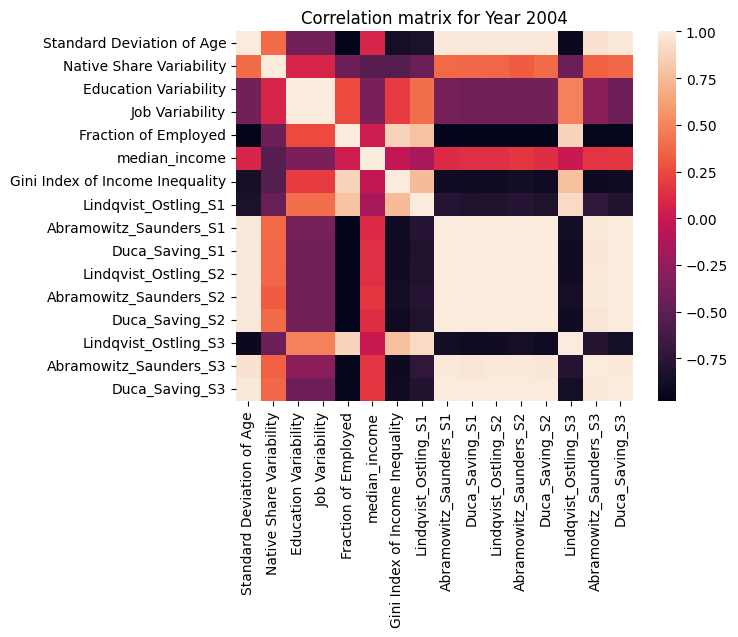

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = output_df.corr()
sns.heatmap(corr_matrix)
plt.title("Correlation matrix for Year 2004")
plt.show()

In [18]:
output_df.to_csv(r"polarization2004_data.csv")

In [19]:
df_residence.head(1)

,nopsocc,nopsocd,nopsoce,nfiyr,nfetype,nage12,njbstatt,nregion2,nplbornc_cc,nfetype_encoded,njbstatt_encoded,nopsocc_encoded,nopsocd_encoded,nopsoce_encoded
0,Strongly agree,Disagree,Disagree,45694.398438,inapplicable,70.0,Retired,London,inapplicable,-8,4,2,-1,-1


### Visualizing distribution of opinions for all statements

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2004')

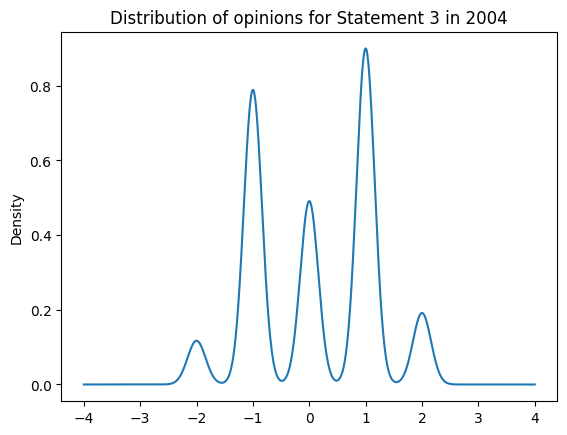

In [20]:
df_residence["nopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2004")

Text(0.5, 1.0, 'Distribution of opinions for Statement 3 in 2004')

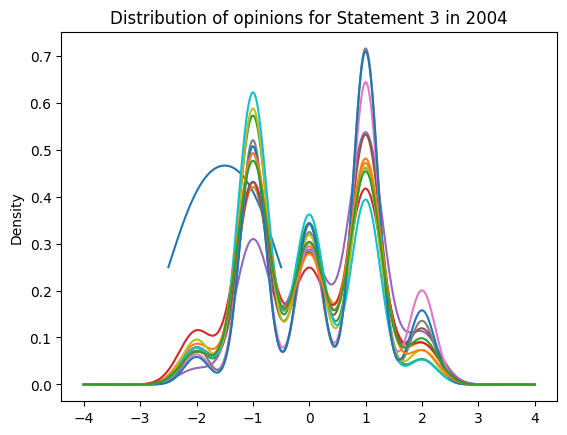

In [21]:
df_residence.groupby("nregion2")["nopsoce_encoded"].plot(kind = "kde")
plt.title("Distribution of opinions for Statement 3 in 2004")

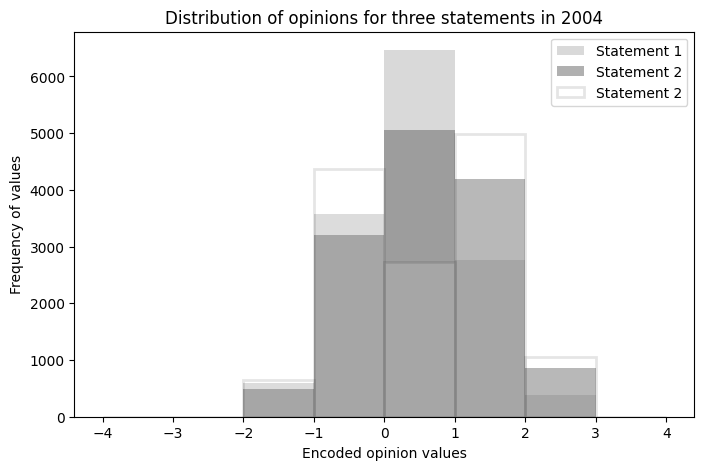

In [22]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(df_residence["nopsocc_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#d9d9d9')
ax.hist(df_residence["nopsocd_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='#636363', alpha = 0.5)
ax.hist(df_residence["nopsoce_encoded"], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], color='white', alpha = 0.1, edgecolor='black', linewidth = 2)

# set title and axis labels
ax.set_title('Distribution of opinions for three statements in 2004')
ax.set_xlabel('Encoded opinion values')
ax.set_ylabel('Frequency of values')

# add a legend
ax.legend(['Statement 1', 'Statement 2', 'Statement 2'], loc='upper right')

plt.show()

In [17]:
output_df.head(1)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3
0,27.428695,1.0,1.0,Channel Islands,1.0,0.0,10603.949219,0.312804,0.5,1.5,125.0,4.5,1.5,375.0,0.5,1.5,125.0


In [18]:
def lo(x):
    return round((x["Lindqvist_Ostling_S1"] + x["Lindqvist_Ostling_S2"] + x["Lindqvist_Ostling_S3"])/3, 1);
def As(x):
    return round((x["Abramowitz_Saunders_S1"] + x["Abramowitz_Saunders_S2"] + x["Abramowitz_Saunders_S3"])/3, 1);
def ds(x):
    return round((x["Duca_Saving_S1"] + x["Duca_Saving_S2"] + x["Duca_Saving_S3"])/3, 1);

output_df["Psd"] = output_df.apply(lambda x: lo(x), axis = 1)
output_df["Pid"] = output_df.apply(lambda x: As(x), axis = 1)
output_df["Pea"] = output_df.apply(lambda x: ds(x), axis = 1)

output_df.head(5)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea
0,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,125.000000,4.500000,1.500000,375.000000,0.500000,1.500000,125.000000,1.8,1.5,208.3
1,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,2.410976,0.891563,0.706147,2.305031,1.168530,0.912782,8.061817,0.9,0.7,4.3
2,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,2.233210,0.840264,0.697047,1.117012,1.013606,0.854942,2.416369,0.8,0.7,1.9
3,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,4.491054,0.995649,0.782875,3.072200,1.276732,0.966102,9.327323,1.0,0.8,5.6
4,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,0.292814,0.882639,0.706897,3.139223,1.028232,0.890173,1.449022,0.9,0.7,1.6


In [19]:
output_df["nPsd"] = (output_df["Psd"] - output_df["Psd"].min()) / (output_df["Psd"].max() - output_df["Psd"].min())
output_df["nPid"] = (output_df["Pid"] - output_df["Pid"].min()) / (output_df["Pid"].max() - output_df["Pid"].min())
output_df["nPea"] = (output_df["Pea"] - output_df["Pea"].min()) / (output_df["Pea"].max() - output_df["Pea"].min())

output_df.head(5)

,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,...,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea,nPsd,nPid,nPea
0,27.428695,1.000000,1.0,Channel Islands,1.0,0.000000,10603.949219,0.312804,0.500000,1.500000,...,375.000000,0.500000,1.500000,125.000000,1.8,1.5,208.3,1.0,1.000,1.000000
1,17.472058,0.952575,368.5,East Midlands,368.5,0.518970,10909.073242,0.459949,0.734366,0.591111,...,2.305031,1.168530,0.912782,8.061817,0.9,0.7,4.3,0.1,0.000,0.013062
2,19.162182,0.930682,439.5,East of England,439.5,0.469318,10939.175781,0.511209,0.678979,0.558524,...,1.117012,1.013606,0.854942,2.416369,0.8,0.7,1.9,0.0,0.000,0.001451
3,18.062912,0.900531,376.5,London,376.5,0.493369,12899.308594,0.513331,0.787962,0.609091,...,3.072200,1.276732,0.966102,9.327323,1.0,0.8,5.6,0.2,0.125,0.019352
4,18.279141,0.914358,198.0,North East,198.0,0.483627,10847.168945,0.460723,0.674639,0.600567,...,3.139223,1.028232,0.890173,1.449022,0.9,0.7,1.6,0.1,0.000,0.000000


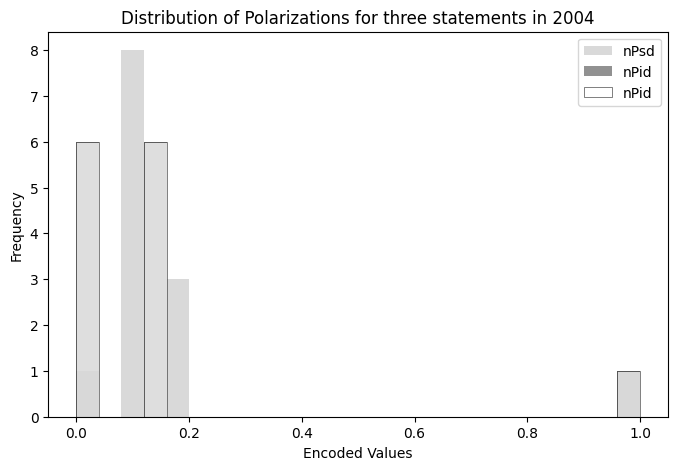

In [20]:
import matplotlib.pyplot as plt

# create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# plot the histograms with different colors and alphas
ax.hist(output_df["nPsd"], bins=25, color='#d9d9d9')
ax.hist(output_df["nPid"], bins=25, color='#252525', alpha = 0.5)
ax.hist(output_df["nPid"], bins=25, color='white', alpha = 0.7, edgecolor='black', linewidth = 0.5)

# set title and axis labels
ax.set_title('Distribution of Polarizations for three statements in 2004')
ax.set_xlabel('Encoded Values')
ax.set_ylabel('Frequency')

# add a legend
ax.legend(['nPsd', 'nPid', 'nPid'], loc='upper right')

plt.show()

In [21]:
output_df.corr()

,std_dev_age,native_share,education_variability,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,...,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,Psd,Pid,Pea,nPsd,nPid,nPea
std_dev_age,1.000000,0.676846,-0.395903,-0.395903,-0.967964,-0.146395,-0.879373,-0.822358,0.976073,0.979784,...,0.981028,-0.925701,0.934355,0.972036,0.944631,0.953813,0.979456,0.944631,0.953813,0.979456
native_share,0.676846,1.000000,-0.238103,-0.238103,-0.659297,-0.233030,-0.749382,-0.503894,0.692433,0.695284,...,0.697370,-0.624546,0.666394,0.689972,0.693464,0.622311,0.695944,0.693464,0.622311,0.695944
education_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,...,-0.395884,0.471881,-0.277126,-0.414343,-0.351179,-0.259831,-0.400442,-0.351179,-0.259831,-0.400442
job_variability,-0.395903,-0.238103,1.000000,1.000000,0.254876,-0.305476,0.222702,0.401772,-0.375514,-0.399625,...,-0.395884,0.471881,-0.277126,-0.414343,-0.351179,-0.259831,-0.400442,-0.351179,-0.259831,-0.400442
frac_employed,-0.967964,-0.659297,0.254876,0.254876,1.000000,0.209151,0.915859,0.791500,-0.973366,-0.973316,...,-0.973526,0.871133,-0.963840,-0.962058,-0.951466,-0.972259,-0.971652,-0.951466,-0.972259,-0.971652
median_income,-0.146395,-0.233030,-0.305476,-0.305476,0.209151,1.000000,0.240857,0.025331,-0.106462,-0.066579,...,-0.079531,0.182489,-0.050258,-0.039393,-0.026332,-0.120645,-0.068954,-0.026332,-0.120645,-0.068954
gini_index,-0.879373,-0.749382,0.222702,0.222702,0.915859,0.240857,1.000000,0.758697,-0.929952,-0.917069,...,-0.923184,0.803016,-0.928328,-0.916213,-0.920628,-0.900421,-0.921089,-0.920628,-0.900421,-0.921089
Lindqvist_Ostling_S1,-0.822358,-0.503894,0.401772,0.401772,0.791500,0.025331,0.758697,1.000000,-0.788894,-0.820737,...,-0.828351,0.910471,-0.738481,-0.810220,-0.724456,-0.738589,-0.823751,-0.724456,-0.738589,-0.823751
Abramowitz_Saunders_S1,0.976073,0.692433,-0.375514,-0.375514,-0.973366,-0.106462,-0.929952,-0.788894,1.000000,0.995786,...,0.996561,-0.880598,0.980434,0.994320,0.985043,0.981864,0.996445,0.985043,0.981864,0.996445
Duca_Saving_S1,0.979784,0.695284,-0.399625,-0.399625,-0.973316,-0.066579,-0.917069,-0.820737,0.995786,1.000000,...,0.999517,-0.894952,0.975335,0.997903,0.977595,0.973009,0.999785,0.977595,0.973009,0.999785
